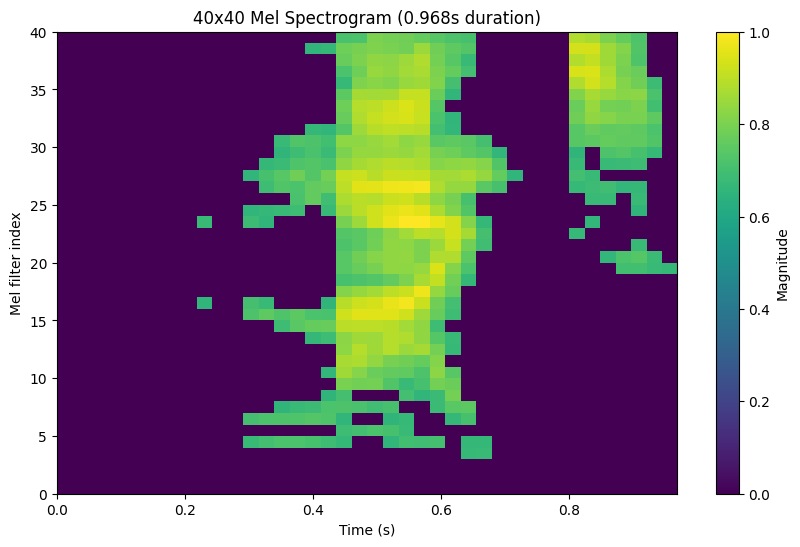

Spectrogram shape: (40, 40)


In [80]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy.fftpack import dct
from scipy.signal import get_window

SAMPLE_RATE = 16000
FRAME_DUR = 0.032
FRAME_SIZE = int(SAMPLE_RATE * FRAME_DUR)
FRAME_STRIDE_DUR = 0.024
FRAME_STRIDE = int(SAMPLE_RATE * FRAME_STRIDE_DUR)
NUM_BINS = FRAME_SIZE // 2
FILTER_NUMBER = 40
MIN_FREQ = 0
MAX_FREQ = SAMPLE_RATE // 2
COEFFICIENT = 0.96875
NOISE_FLOOR = -40.0

def pre_emphasis(audio):
    emphasized = np.zeros_like(audio, dtype=np.float32)
    emphasized[0] = audio[0] / 32768.0
    for i in range(1, len(audio)):
        emphasized[i] = (audio[i] / 32768.0) - COEFFICIENT * (audio[i-1] / 32768.0)
    return emphasized

def apply_windowing(frame):
    window = 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(len(frame)) / (len(frame) - 1))
    return frame * window

def hz_to_mel(hz):
    return 1127.0 * np.log10(1 + hz / 700.0)

def mel_to_hz(mel):
    return 700 * (10 ** (mel / 1127.0) - 1)

def create_mel_filterbank():
    min_mel = hz_to_mel(MIN_FREQ)
    max_mel = hz_to_mel(MAX_FREQ)
    #mel_points = np.linspace(min_mel, max_mel, FILTER_NUMBER + 2)
    #hz_points = mel_to_hz(mel_points)
    mel_points = np.zeros(FILTER_NUMBER + 2)
    mel_spacing = (max_mel - min_mel) / (FILTER_NUMBER + 1)
    for i in range(FILTER_NUMBER + 2):
        mel_points[i] = mel_to_hz(min_mel + i * mel_spacing)
        if mel_points[i] > MAX_FREQ:
            mel_points[i] = MAX_FREQ

    #bin_indices = np.floor((NUM_BINS) * hz_points / (SAMPLE_RATE / 2)).astype(int)
    #bin_indices = np.clip(bin_indices, 0, NUM_BINS - 1)
    bin_indices = np.zeros(FILTER_NUMBER + 2, dtype=int)
    for i in range(FILTER_NUMBER + 2):
        bin_indices[i] = int(mel_points[i] * (NUM_BINS - 1) / (SAMPLE_RATE / 2.0))
        bin_indices[i] = max(0, min(NUM_BINS - 1, bin_indices[i]))

    filterbank = np.zeros((FILTER_NUMBER, NUM_BINS))

    for i in range(FILTER_NUMBER):
        left = bin_indices[i]
        middle = bin_indices[i+1]
        right = bin_indices[i+2]

        if left == middle:
            middle = min(left + 1, NUM_BINS - 1)
        if middle == right:
            right = min(middle + 1, NUM_BINS - 1)

        #filterbank[i, left:middle] = np.linspace(0, 1, middle - left)
        for j in range(left, middle):
            filterbank[i, j] = (j - left) / (middle - left)

        #filterbank[i, middle:right] = np.linspace(1, 0, right - middle)
        for j in range(middle, right):
            filterbank[i, j] = 1.0 - (j - middle) / (right - middle)
    return filterbank

def compute_spectrogram(audio, show_plot=True):
    num_samples = len(audio)

    total_duration = num_samples / SAMPLE_RATE
    num_frames_full_second = int((total_duration - FRAME_DUR) / FRAME_STRIDE_DUR) + 1
    num_frames = min(num_frames_full_second, 40)
    pre_emphasis_array = pre_emphasis(audio)
    spectrogram = np.zeros((num_frames, NUM_BINS))

    for frame in range(num_frames):
        start = frame * FRAME_STRIDE
        end = start + FRAME_SIZE
        segment = pre_emphasis_array[start:end]
        if len(segment) < FRAME_SIZE:
            segment = np.pad(segment, (0, FRAME_SIZE - len(segment)))

        windowed = apply_windowing(segment)
        fft = np.fft.rfft(windowed, n=FRAME_SIZE)
        magnitude = np.abs(fft)
        spectrogram[frame] = magnitude[:NUM_BINS]

    mel_filterbank = create_mel_filterbank()
    mel_spectrogram = np.dot(spectrogram, mel_filterbank.T)
    log_mel_spectrogram = 10 * np.log10(mel_spectrogram + 1e-20)

    log_mel_spectrogram = (log_mel_spectrogram - NOISE_FLOOR) / (-NOISE_FLOOR + 12)
    log_mel_spectrogram = np.clip(log_mel_spectrogram, 0, 1)
    quantized = np.round(log_mel_spectrogram * 256) / 256.0
    quantized = np.where(quantized >= 0.65, quantized, 0)
    quantized = quantized[:40]

    if show_plot:
        plt.figure(figsize=(10, 6))
        time_axis = np.linspace(0, 0.968, 40)
        plt.imshow(quantized.T, aspect='auto', origin='lower',
                  extent=[0, 0.968, 0, FILTER_NUMBER])
        plt.colorbar(label='Magnitude')
        plt.xlabel('Time (s)')
        plt.ylabel('Mel filter index')
        plt.title('40x40 Mel Spectrogram (0.968s duration)')
        plt.show()

    return quantized

if __name__ == "__main__":
    audio_file = "matteo.wav"
    audio, sr = librosa.load(audio_file, sr=SAMPLE_RATE, mono=True)

    audio_int16 = (audio * 32768).astype(np.int16)

    required_samples = int(0.968 * SAMPLE_RATE)
    audio_int16 = audio_int16[:required_samples]

    mel_spectrogram = compute_spectrogram(audio_int16)
    print(f"Spectrogram shape: {mel_spectrogram.shape}")

    with open('mfe_features_formatted.txt', 'w') as f:
      for row in mel_spectrogram:
          # Write each row with 6 decimal places, space-separated
          line = ' '.join([f'{x:.6f}' for x in row])
          f.write(line + '\n')


In [82]:
import numpy as np
import re

def parse_header_file(header_path):
    """Enhanced parser that handles all parameters from your header"""
    with open(header_path, 'r') as f:
        content = f.read()

    weights = {}

    # Extract all arrays (weights, biases, and batch norm)
    array_pattern = re.compile(r'static const float (\w+)\[(\d+)\] = {([^}]*)};')
    for match in array_pattern.finditer(content):
        name, size, values = match.groups()
        float_values = [float(v.strip().rstrip('f')) for v in values.split(',') if v.strip()]
        weights[name] = np.array(float_values, dtype=np.float32)

        # Reshape convolutional weights
        if name == 'conv_1_Weights':
            weights[name] = weights[name].reshape(3, 3, 1, 8)
        elif name == 'conv_2_Weights':
            weights[name] = weights[name].reshape(3, 3, 8, 16)
        elif name == 'conv_3_Weights':
            weights[name] = weights[name].reshape(3, 3, 16, 32)
        elif name == 'conv_4_Weights':
            weights[name] = weights[name].reshape(3, 3, 32, 64)

    return weights

def sv_neural_network_py(mfe_input, weights):
    """Complete network with verified batch normalization"""
    # Layer 1: Batch Normalization (using your exact params)
    batchNorm = (mfe_input) * weights['batch_norm_mul'] - weights['batch_norm_sub']

    # Layer 2: Conv2D (8 channels)
    conv1 = conv2d(batchNorm,
                  weights['conv_1_Weights'],
                  weights['conv_1_BiasAdd_ReadVariableOp'],
                  stride=1)

    # Layer 3: MaxPool (3x3)
    maxPool1 = max_pool2d(conv1, pool_size=3)
    #np.savetxt('d_vector.txt', conv1.flatten(), fmt='%.6f')
    # Layer 4: Conv2D (16 channels)
    conv2 = conv2d(maxPool1,
                  weights['conv_2_Weights'],
                  weights['conv_2_BiasAdd_ReadVariableOp'],
                  stride=1)

    # Layer 5: MaxPool (2x2)
    maxPool2 = max_pool2d(conv2, pool_size=2)

    # Layer 6: Conv2D (32 channels, stride 2)
    conv3 = conv2d(maxPool2,
                  weights['conv_3_Weights'],
                  weights['conv_3_BiasAdd_ReadVariableOp'],
                  stride=2)

    # Layer 7: Conv2D (64 channels, stride 2)
    conv4 = conv2d(conv3,
                  weights['conv_4_Weights'],
                  weights['conv_4_BiasAdd_ReadVariableOp'],
                  stride=2)

    return conv4.flatten()  # 256-dim d-vector

# Complete implementation with all helper functions
def conv2d(input_data, weights, bias, stride=1, padding='same'):
    # Get dimensions
    in_height, in_width, in_channels = input_data.shape
    kernel_size, _, _, out_channels = weights.shape

    # Calculate output dimensions
    if padding == 'same':
        out_height = int(np.ceil(in_height / stride))
        out_width = int(np.ceil(in_width / stride))
        pad_h = max((out_height - 1) * stride + kernel_size - in_height, 0)
        pad_w = max((out_width - 1) * stride + kernel_size - in_width, 0)
        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top
        pad_left = pad_w // 2
        pad_right = pad_w - pad_left
    else:  # valid
        out_height = (in_height - kernel_size) // stride + 1
        out_width = (in_width - kernel_size) // stride + 1
        pad_top, pad_bottom, pad_left, pad_right = 0, 0, 0, 0
    # Pad input
    padded_input = np.pad(input_data,
                         ((pad_top, pad_bottom),
                          (pad_left, pad_right),
                          (0, 0)),
                         mode='constant')

    # Initialize output
    output = np.zeros((out_height, out_width, out_channels))

    # Perform convolution
    for i in range(out_height):
        for j in range(out_width):
            h_start = i * stride
            h_end = h_start + kernel_size
            w_start = j * stride
            w_end = w_start + kernel_size

            # Extract patch and compute dot product
            patch = padded_input[h_start:h_end, w_start:w_end, :]
            output[i,j] = np.tensordot(patch, weights, axes=([0,1,2],[0,1,2])) + bias

    return output

def max_pool2d(input_data, pool_size=2):
    """Max pooling implementation matching C behavior"""
    in_height, in_width, channels = input_data.shape
    out_height = in_height // pool_size
    out_width = in_width // pool_size

    output = np.zeros((out_height, out_width, channels))

    for i in range(out_height):
        for j in range(out_width):
            h_start = i * pool_size
            h_end = h_start + pool_size
            w_start = j * pool_size
            w_end = w_start + pool_size

            patch = input_data[h_start:h_end, w_start:w_end, :]
            output[i,j] = np.max(patch, axis=(0,1))

    return output
def load_mfe_features(filename):
    """Load MFCC features from the formatted text file"""
    with open(filename, 'r') as f:
        # Read all lines and convert to float
        features = []
        for line in f:
            if line.startswith('#'):  # Skip comment lines
                continue
            features.append([float(x) for x in line.strip().split()])

    # Convert to numpy array and reshape
    mfe_array = np.array(features, dtype=np.float32)

    # Assuming the format is (time_frames × mfcc_coefficients)
    # We need to reshape to (40, 40, 1) for the network input
    if mfe_array.shape == (40, 40):
        return mfe_array.reshape(40, 40, 1)
    else:
        raise ValueError(f"Unexpected feature shape {mfe_array.shape}. Expected 40x40 features.")

# Example usage with dummy input
if __name__ == "__main__":
    # Load weights from header file
    weights = parse_header_file('d_vector_extractor.h')

    # Create dummy input (40x40 MFCC)
    #dummy_input = np.random.rand(40, 40, 1).astype(np.float32)

    # Run the network
    #d_vector = sv_neural_network_py(dummy_input, weights)
    print("Generated d-vector shape:", d_vector.shape)
    # After generating the d_vector
    mfe_input=load_mfe_features("mfe_features_formatted.txt")
    d_vector = sv_neural_network_py(mfe_input, weights)

    # Save to text file (human-readable)
    np.savetxt('d_vector.txt', d_vector, fmt='%.6f')

Generated d-vector shape: (256,)


In [78]:
def compare_float_files(file1_path, file2_path):
    try:
        with open(file1_path, 'r') as file1, open(file2_path, 'r') as file2:
            line_number = 0
            discrepancies_found = False
            discrepancies=0

            while True:
                line1 = file1.readline()
                line2 = file2.readline()
                line_number += 1

                # Check if both files have reached the end
                if not line1 and not line2:
                    break

                # Check if one file is longer than the other
                if not line1 or not line2:
                    print(f"Files have different number of lines. File {'1' if not line1 else '2'} is shorter.")
                    discrepancies_found = True
                    break

                try:
                    # Convert lines to floats
                    float1 = float(line1.strip())
                    float2 = float(line2.strip())

                    # Compare the float values
                    if abs(float1-float2) > 0.0001:
                        print(f"Line {line_number}: {float1} != {float2}")
                        discrepancies_found = True
                        discrepancies=discrepancies+1

                except ValueError:
                    print(f"Error converting values to float on line {line_number}")
                    discrepancies_found = True
                    continue

            if not discrepancies_found:
                print("That's all ok")
            else:
              print(f"Number Discrepancies: {discrepancies}")

    except FileNotFoundError as e:
        print(f"Error: {e}")

# Example usage:
file1_path = input("Enter path to first file: ")
file2_path = input("Enter path to second file: ")
compare_float_files(file1_path, file2_path)

Enter path to first file: debug.txt
Enter path to second file: spectrogram.txt
That's all ok
